In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import os
import sys
import PIL as pil
from sklearn import metrics, preprocessing
import cv2
import shap
import lime
from lime import lime_image
from skimage.segmentation import mark_boundaries
from imblearn.over_sampling import RandomOverSampler
from imblearn.keras import balanced_batch_generator
from sklearn.utils import class_weight

In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model

In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
train_dir = os.path.join('dataset', 'images', 'train')
test_dir = os.path.join('dataset', 'images', 'test')

In [34]:
img_height = 224
img_width = 224
num_classes = 7
batch_size = 32
#CLASSES = ['neutral', 'happy', 'sad', 'surprised', 'fear', 'disgusted', 'angry', 'contempt']
#CLASSES = ['anger', 'contempt', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprised']
CLASSES = ['angery', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

In [35]:
train_datagen = ImageDataGenerator(horizontal_flip=True,
                                  vertical_flip=True,
                                  width_shift_range=0.1,
                                  height_shift_range=0.1,
                                  rotation_range=60,
                                  rescale=1./255,
                                  validation_split=0.3)

test_datagen = ImageDataGenerator(rescale=1./255,
                                 validation_split=0.3)

train_generator = train_datagen.flow_from_directory(directory=train_dir,
                                                    target_size=(img_height, img_width),
                                                    batch_size= batch_size,
                                                    shuffle=True,
                                                    color_mode='rgb',
                                                    class_mode='categorical',
                                                    subset='training')

validation_generator = test_datagen.flow_from_directory(directory=train_dir,
                                                    target_size=(img_height, img_width),
                                                    batch_size= batch_size,
                                                    shuffle=True,
                                                    color_mode='rgb',
                                                    class_mode='categorical',
                                                    subset='validation')

test_generator = test_datagen.flow_from_directory(directory=test_dir,
                                                    target_size=(img_height, img_width),
                                                    batch_size= batch_size,
                                                    shuffle=True,
                                                    color_mode='rgb',
                                                    class_mode='categorical')

Found 20099 images belonging to 7 classes.
Found 8610 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [36]:
class_weights = class_weight.compute_class_weight('balanced', 
                                                  classes=np.unique(train_generator.classes), 
                                                  y=train_generator.classes)

train_class_weights = dict(enumerate(class_weights))

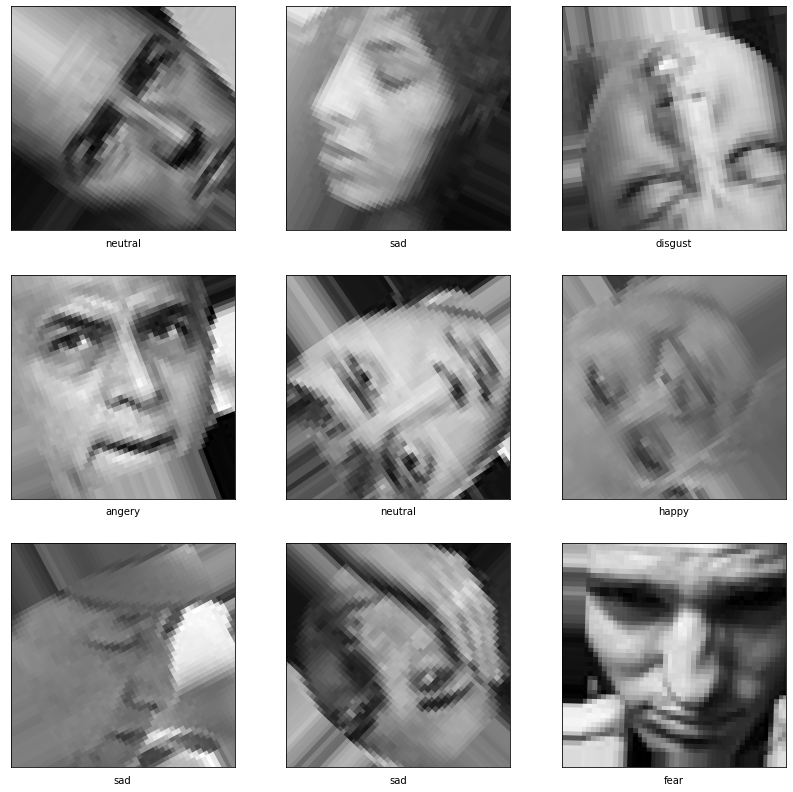

In [37]:
image, classes = next(train_generator)

class_idxs = np.argmax(classes, axis=-1) 
labels = [CLASSES[idx] for idx in class_idxs]

plt.figure(figsize=(14, 14))

for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow((image[i]))
    plt.xlabel(labels[i])
plt.show()

In [58]:
mobileNet = tf.keras.applications.MobileNetV2(include_top=False, weights = 'imagenet', input_shape=(img_height, img_width, 3))

for layer in mobileNet.layers:
    layer.trainable = False
    
mobileNet.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_6[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

 block_3_expand_relu (ReLU)     (None, 56, 56, 144)  0           ['block_3_expand_BN[0][0]']      
                                                                                                  
 block_3_pad (ZeroPadding2D)    (None, 57, 57, 144)  0           ['block_3_expand_relu[0][0]']    
                                                                                                  
 block_3_depthwise (DepthwiseCo  (None, 28, 28, 144)  1296       ['block_3_pad[0][0]']            
 nv2D)                                                                                            
                                                                                                  
 block_3_depthwise_BN (BatchNor  (None, 28, 28, 144)  576        ['block_3_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_3_d

 lization)                                                                                        
                                                                                                  
 block_7_expand (Conv2D)        (None, 14, 14, 384)  24576       ['block_6_project_BN[0][0]']     
                                                                                                  
 block_7_expand_BN (BatchNormal  (None, 14, 14, 384)  1536       ['block_7_expand[0][0]']         
 ization)                                                                                         
                                                                                                  
 block_7_expand_relu (ReLU)     (None, 14, 14, 384)  0           ['block_7_expand_BN[0][0]']      
                                                                                                  
 block_7_depthwise (DepthwiseCo  (None, 14, 14, 384)  3456       ['block_7_expand_relu[0][0]']    
 nv2D)    

                                                                                                  
 block_10_depthwise_relu (ReLU)  (None, 14, 14, 384)  0          ['block_10_depthwise_BN[0][0]']  
                                                                                                  
 block_10_project (Conv2D)      (None, 14, 14, 96)   36864       ['block_10_depthwise_relu[0][0]']
                                                                                                  
 block_10_project_BN (BatchNorm  (None, 14, 14, 96)  384         ['block_10_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_11_expand (Conv2D)       (None, 14, 14, 576)  55296       ['block_10_project_BN[0][0]']    
                                                                                                  
 block_11_

 block_14_depthwise (DepthwiseC  (None, 7, 7, 960)   8640        ['block_14_expand_relu[0][0]']   
 onv2D)                                                                                           
                                                                                                  
 block_14_depthwise_BN (BatchNo  (None, 7, 7, 960)   3840        ['block_14_depthwise[0][0]']     
 rmalization)                                                                                     
                                                                                                  
 block_14_depthwise_relu (ReLU)  (None, 7, 7, 960)   0           ['block_14_depthwise_BN[0][0]']  
                                                                                                  
 block_14_project (Conv2D)      (None, 7, 7, 160)    153600      ['block_14_depthwise_relu[0][0]']
                                                                                                  
 block_14_

In [59]:
unfreeze = False

for layer in mobileNet.layers:
    if unfreeze:
        layer.trainable = True
    if layer.name == 'block_15_add':
        unfreeze = True
        
mobileNet.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_6[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

 block_3_expand_relu (ReLU)     (None, 56, 56, 144)  0           ['block_3_expand_BN[0][0]']      
                                                                                                  
 block_3_pad (ZeroPadding2D)    (None, 57, 57, 144)  0           ['block_3_expand_relu[0][0]']    
                                                                                                  
 block_3_depthwise (DepthwiseCo  (None, 28, 28, 144)  1296       ['block_3_pad[0][0]']            
 nv2D)                                                                                            
                                                                                                  
 block_3_depthwise_BN (BatchNor  (None, 28, 28, 144)  576        ['block_3_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_3_d

 lization)                                                                                        
                                                                                                  
 block_7_expand (Conv2D)        (None, 14, 14, 384)  24576       ['block_6_project_BN[0][0]']     
                                                                                                  
 block_7_expand_BN (BatchNormal  (None, 14, 14, 384)  1536       ['block_7_expand[0][0]']         
 ization)                                                                                         
                                                                                                  
 block_7_expand_relu (ReLU)     (None, 14, 14, 384)  0           ['block_7_expand_BN[0][0]']      
                                                                                                  
 block_7_depthwise (DepthwiseCo  (None, 14, 14, 384)  3456       ['block_7_expand_relu[0][0]']    
 nv2D)    

                                                                                                  
 block_10_depthwise_relu (ReLU)  (None, 14, 14, 384)  0          ['block_10_depthwise_BN[0][0]']  
                                                                                                  
 block_10_project (Conv2D)      (None, 14, 14, 96)   36864       ['block_10_depthwise_relu[0][0]']
                                                                                                  
 block_10_project_BN (BatchNorm  (None, 14, 14, 96)  384         ['block_10_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_11_expand (Conv2D)       (None, 14, 14, 576)  55296       ['block_10_project_BN[0][0]']    
                                                                                                  
 block_11_

 block_14_depthwise (DepthwiseC  (None, 7, 7, 960)   8640        ['block_14_expand_relu[0][0]']   
 onv2D)                                                                                           
                                                                                                  
 block_14_depthwise_BN (BatchNo  (None, 7, 7, 960)   3840        ['block_14_depthwise[0][0]']     
 rmalization)                                                                                     
                                                                                                  
 block_14_depthwise_relu (ReLU)  (None, 7, 7, 960)   0           ['block_14_depthwise_BN[0][0]']  
                                                                                                  
 block_14_project (Conv2D)      (None, 7, 7, 160)    153600      ['block_14_depthwise_relu[0][0]']
                                                                                                  
 block_14_

In [60]:
def classifier(inputs):
    
    x = tf.keras.layers.GlobalAveragePooling2D()(inputs)
    x = tf.keras.layers.Dense(512, activation = 'relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(1028, activation = 'relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(num_classes, activation = 'softmax')(x)
    
    return x

def define_model(trained_model):
    
    inputs = tf.keras.layers.Input(shape=(img_height, img_width, 3))
    intermediate = trained_model(inputs)
    classification_output = classifier(intermediate)
    
    model = tf.keras.Model(inputs=inputs, outputs=classification_output)
    
    model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
                               loss=tf.keras.losses.categorical_crossentropy,
                               metrics = ['accuracy'])
    
    return model
    

In [9]:
mobileNet_model = load_model(os.path.join('M.h5'))

In [61]:
mobileNet_model = define_model(mobileNet)

mobileNet_model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_3   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_7 (Dense)             (None, 512)               655872    
                                                                 
 dropout_4 (Dropout)         (None, 512)               0         
                                                                 
 dense_8 (Dense)             (None, 1028)              5273

In [ ]:
mob_checkpoint_path = os.path.join('training', 'MobileNetv2\ ')
mob_callback = tf.keras.callbacks.ModelCheckpoint(filepath=mob_checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

m_history = mobileNet_model.fit_generator(train_generator, validation_data=validation_generator, callbacks=[mob_callback],
                                         epochs=20, class_weight=train_class_weights)

`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/20
629/629 [==============================] - ETA: 0s - loss: 1.3852 - accuracy: 0.4811
Epoch 1: saving model to training\MobileNetv2\ 
629/629 [==============================] - 119s 186ms/step - loss: 1.3852 - accuracy: 0.4811 - val_loss: 1.3787 - val_accuracy: 0.4909
Epoch 2/20
629/629 [==============================] - ETA: 0s - loss: 1.3539 - accuracy: 0.4870
Epoch 2: saving model to training\MobileNetv2\ 
629/629 [==============================] - 119s 189ms/step - loss: 1.3539 - accuracy: 0.4870 - val_loss: 1.3655 - val_accuracy: 0.4928
Epoch 3/20
629/629 [==============================] - ETA: 0s - loss: 1.3544 - accuracy: 0.4856
Epoch 3: saving model to training\MobileNetv2\ 
629/629 [==============================] - 116s 184ms/step - loss: 1.3544 - accuracy: 0.4856 - val_loss: 1.3642 - val_accuracy: 0.4915
Epoch 4/20
629/629 [==============================] - ETA: 0s - loss: 1.3489 - accuracy: 0.4883
Epoch 4: saving model to training\MobileNetv2\ 
629/629 [==========

In [51]:
mob_checkpoint_path = os.path.join('training', 'MobileNetv2\ ')
mob_callback = tf.keras.callbacks.ModelCheckpoint(filepath=mob_checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

m_history = mobileNet_model.fit(x = train_generator, validation_data = validation_generator, callbacks = [mob_callback],
                                 epochs=20)

Epoch 1/20
629/629 [==============================] - ETA: 0s - loss: 1.2288 - accuracy: 0.5390
Epoch 1: saving model to training\MobileNetv2\ 
629/629 [==============================] - 123s 193ms/step - loss: 1.2288 - accuracy: 0.5390 - val_loss: 1.2867 - val_accuracy: 0.5213
Epoch 2/20
629/629 [==============================] - ETA: 0s - loss: 1.2296 - accuracy: 0.5431
Epoch 2: saving model to training\MobileNetv2\ 
629/629 [==============================] - 130s 206ms/step - loss: 1.2296 - accuracy: 0.5431 - val_loss: 1.2803 - val_accuracy: 0.5199
Epoch 3/20
 93/629 [===>..........................] - ETA: 1:33 - loss: 1.2595 - accuracy: 0.5242

KeyboardInterrupt: 

In [36]:
m_history_d = pd.DataFrame(m_history.history)

In [37]:
m_history_df = pd.concat([m_history_df, m_history_d])

In [46]:
mobileNet_model.layers[1].trainable = False

In [64]:
mobileNet_model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate = 0.001, momentum = 0.9),
                               loss=tf.keras.losses.categorical_crossentropy,
                               metrics = ['accuracy'])

In [32]:
mobileNet_model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001, momentum = 0.1),
                       loss = tf.keras.losses.categorical_crossentropy,
                       metrics = ['accuracy'])

In [50]:
mobileNet_model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
                               loss=tf.keras.losses.categorical_crossentropy,
                               metrics = ['accuracy'])

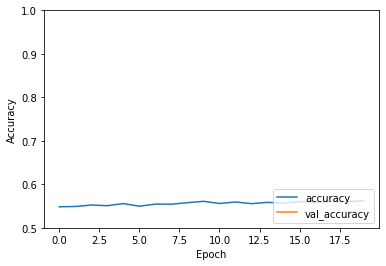

In [43]:
plt.plot(m_history.history['accuracy'], label='accuracy')
plt.plot(m_history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

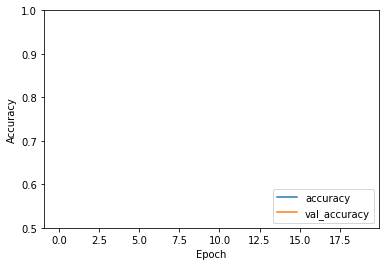

In [44]:
plt.plot(m_history.history['loss'], label='accuracy')
plt.plot(m_history.history['val_loss'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

In [52]:
mobileNet_model.evaluate(test_generator)

225/225 [==============================] - 6s 27ms/step - loss: 1.2899 - accuracy: 0.5230


[1.2899186611175537, 0.522986888885498]

1/1 [==============================] - 0s 468ms/step


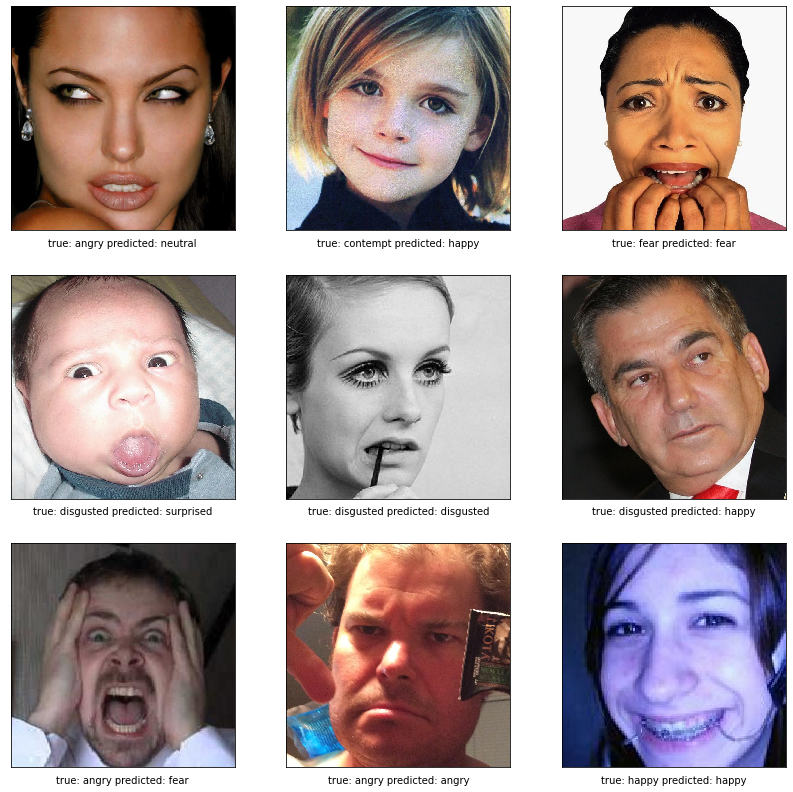

In [11]:
test_image, test_class = next(test_generator)

prediction = mobileNet_model.predict(test_image)

predictions = np.argmax(prediction, axis = -1)

class_idxs = np.argmax(test_class, axis=-1) 
labels = [CLASSES[idx] for idx in class_idxs]
predictions_label = [CLASSES[idx] for idx in predictions]

plt.figure(figsize=(14, 14))

for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow((test_image[i]))
    plt.xlabel(f'true: {labels[i]} predicted: {predictions_label[i]}', backgroundcolor = 'w')
plt.show()

In [15]:
def shap_xai(img):
    def f(X):
        tmp = X.copy()
        return mobileNet_model(tmp)

    masker = shap.maskers.Image("inpaint_telea", test_image[0].shape)

    explainer = shap.Explainer(f, masker, ouput_names = CLASSES)

    shap_values = explainer(img[:1], max_evals=1000, batch_size=16, outputs=shap.Explanation.argsort.flip[:1])
    shap.image_plot(shap_values)

In [20]:
def lime_xai(img):
    explainer_lime = lime_image.LimeImageExplainer()

    explanation = explainer_lime.explain_instance(img.astype('double'), 
                                                  mobileNet_model.predict, 
                                                  top_labels=8, 
                                                  hide_color=0, 
                                                  num_samples=1000)
    
    print("Masked region of image: ")
    
    temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], 
                                                positive_only=True, 
                                                num_features=8, hide_rest=True)
    plt.imshow(mark_boundaries(temp, mask))
    plt.show()
    
    print("A heat of the image for most favoured label: ")
    
    #Select the same class explained on the figures above.
    ind =  explanation.top_labels[0]

    #Map each explanation weight to the corresponding superpixel
    dict_heatmap = dict(explanation.local_exp[ind])
    heatmap = np.vectorize(dict_heatmap.get)(explanation.segments) 

    #Plot. The visualization makes more sense if a symmetrical colorbar is used.
    plt.imshow(heatmap, cmap = 'RdBu', vmin  = -heatmap.max(), vmax = heatmap.max())
    plt.colorbar()
    plt.show()

# Correct Predictions with Shap

  0%|          | 0/998 [00:00<?, ?it/s]

Partition explainer: 2it [00:17, 17.62s/it]                                                                            


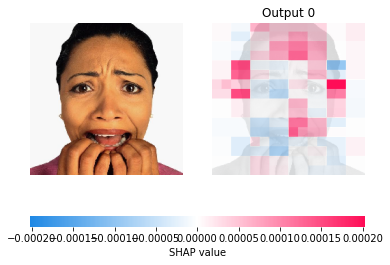

true: fear  predicted: fear


  0%|          | 0/998 [00:00<?, ?it/s]

Partition explainer: 2it [00:29, 29.78s/it]                                                                            


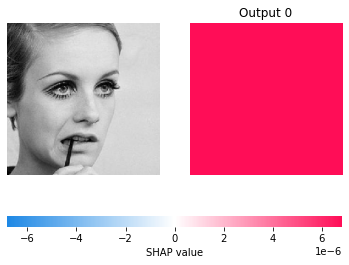

true: disgusted  predicted: disgusted


  0%|          | 0/998 [00:00<?, ?it/s]

Partition explainer: 2it [00:20, 20.11s/it]                                                                            


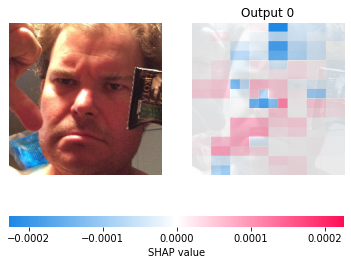

true: angry  predicted: angry


  0%|          | 0/998 [00:00<?, ?it/s]

Partition explainer: 2it [00:15, 15.29s/it]                                                                            


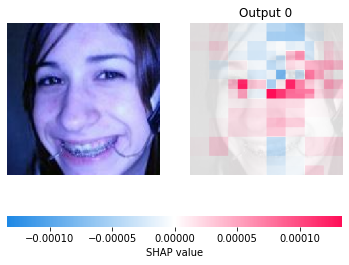

true: happy  predicted: happy


  0%|          | 0/998 [00:00<?, ?it/s]

Partition explainer: 2it [00:28, 28.69s/it]                                                                            


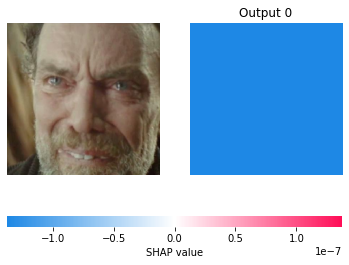

true: sad  predicted: sad


In [17]:
count = 0

for i in range(32):
    if predictions_label[i] == labels[i]:
        shap_xai(test_image[i : i+1])
        print(f'true: {labels[i]}  predicted: {predictions_label[i]}')
        count += 1
        if count == 5:
            break

# Wrong Prediction with Shap

  0%|          | 0/998 [00:00<?, ?it/s]

Partition explainer: 2it [00:21, 21.90s/it]                                                                            


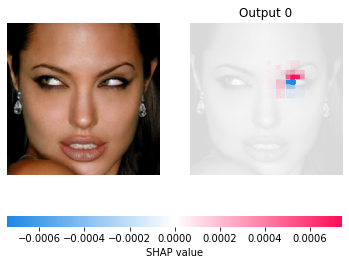

true: angry  predicted: neutral


  0%|          | 0/998 [00:00<?, ?it/s]

Partition explainer: 2it [00:18, 18.80s/it]                                                                            


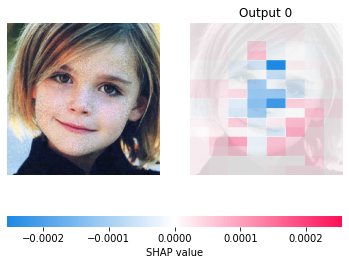

true: contempt  predicted: happy


  0%|          | 0/998 [00:00<?, ?it/s]

Partition explainer: 2it [00:19, 19.91s/it]                                                                            


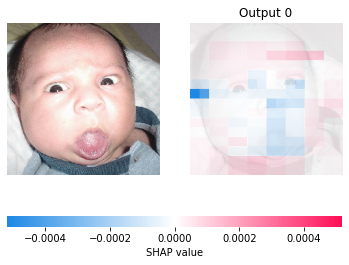

true: disgusted  predicted: surprised


In [18]:
count = 0

for i in range(32):
    if predictions_label[i] != labels[i]:
        shap_xai(test_image[i : i+1])
        print(f'true: {labels[i]}  predicted: {predictions_label[i]}')
        count += 1
        if count == 3:
            break

# Correct Prediction with Lime

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step
Masked region of image: 


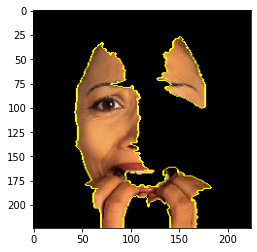

A heat of the image for most favoured label: 


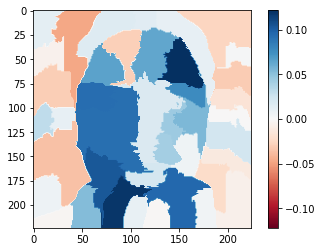

true: fear  predicted: fear


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 17ms/step
Masked region of image: 


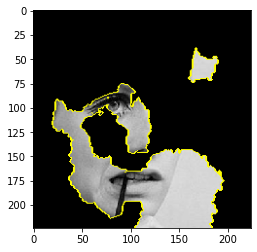

A heat of the image for most favoured label: 


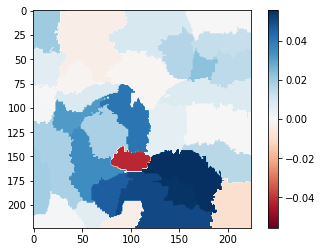

true: disgusted  predicted: disgusted


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 17ms/step
Masked region of image: 


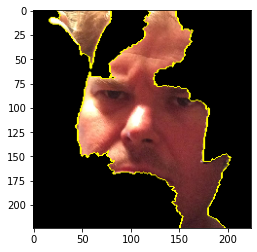

A heat of the image for most favoured label: 


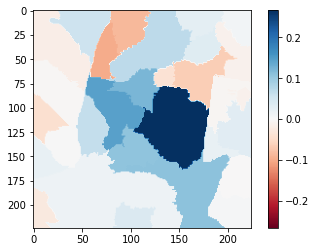

true: angry  predicted: angry


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step
Masked region of image: 


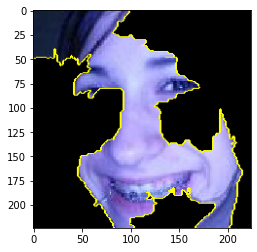

A heat of the image for most favoured label: 


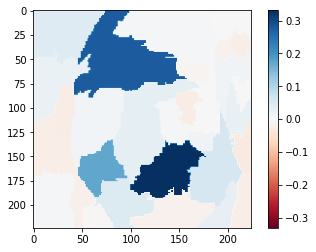

true: happy  predicted: happy


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step
Masked region of image: 


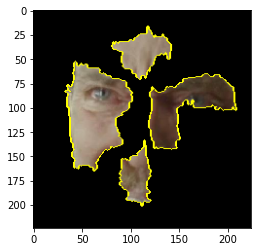

A heat of the image for most favoured label: 


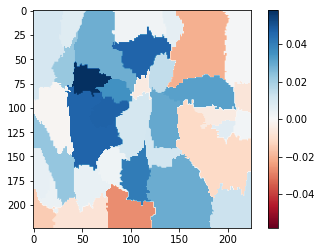

true: sad  predicted: sad


In [21]:
count = 0

for i in range(32):
    if predictions_label[i] == labels[i]:
        lime_xai(test_image[i])
        print(f'true: {labels[i]}  predicted: {predictions_label[i]}')
        count += 1
        if count == 5:
            break

# Wrong Prediction with Lime

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 17ms/step
Masked region of image: 


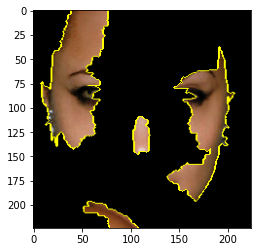

A heat of the image for most favoured label: 


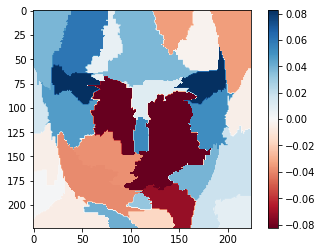

true: angry  predicted: neutral


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step
Masked region of image: 


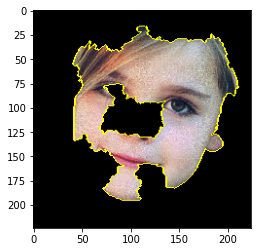

A heat of the image for most favoured label: 


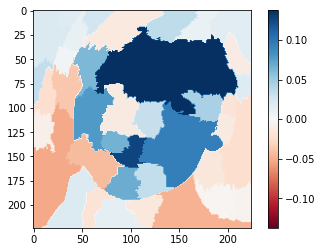

true: contempt  predicted: happy


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step
Masked region of image: 


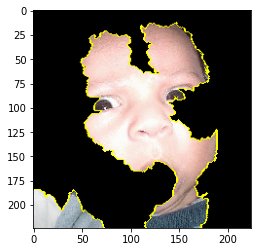

A heat of the image for most favoured label: 


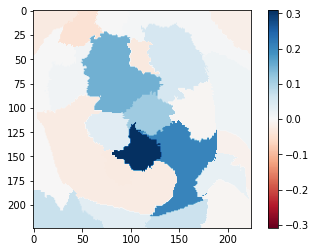

true: disgusted  predicted: surprised


In [22]:
count = 0

for i in range(32):
    if predictions_label[i] != labels[i]:
        lime_xai(test_image[i])
        print(f'true: {labels[i]}  predicted: {predictions_label[i]}')
        count += 1
        if count == 3:
            break

In [14]:
mobileNet_model.save('MobileNet_retrained.h5')

In [24]:
mobileNet_model.save('M.h5')